**Image Classification using Quantum Convolution**

The algorithm presented here is an improved version of eyeQCNN1.ipynb. The images are resized to 28x28 and the full training set is used for the training. At the end of 30 epochs of training, accuracy is improved to ~80% for both training and validation sets.




**Ref**: [1] Pennylane Demos/Quantum Machine Learning/Quanvolutional Neural Networks
     [2] Quanvolutional Neural Networks: Powering Image Recognition with Quantum Circuits Henderson et al.(2019)
     
    
**Tools used** : Pennylane, Tensorflow

!pip install pennylane

!pip install matplotlib

In [1]:
import pennylane as qml
from pennylane import numpy as np

!pip install opencv-python

In [2]:
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt


In [3]:
import os, glob, cv2
import pandas as pd
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import get_custom_objects

In [4]:
SEED = 42
IMG_HEIGHT = 28
IMG_WIDTH = 28

# eye_diseases_classification dataset
IMG_ROOT = 'D:\Womanium2023\GlobalQuantumProject\Datasets\eye_diseases_classification\Proc\\'
IMG_DIR = [IMG_ROOT+'normal',
           IMG_ROOT+'cataract']

In [5]:
IMG_DIR

['D:\\Womanium2023\\GlobalQuantumProject\\Datasets\\eye_diseases_classification\\Proc\\normal',
 'D:\\Womanium2023\\GlobalQuantumProject\\Datasets\\eye_diseases_classification\\Proc\\cataract']

In [6]:
def seed_everything(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

seed_everything(SEED)

In [6]:
df = pd.DataFrame(0,
                  columns=['paths',
                           'cataract'],
                  index=range(2500))

filepaths = glob.glob(IMG_ROOT + '*/*')

for i, filepath in enumerate(filepaths):
    filepath = os.path.split(filepath)
    df.iloc[i, 0] = filepath[0] + '/' + filepath[1]

    if filepath[0] == IMG_DIR[0]:    # normal
            df.iloc[i, 1] = 0
    elif filepath[0] == IMG_DIR[1]:  # cataract
            df.iloc[i, 1] = 1

In [7]:
df = df[df.paths !=0]


In [10]:
df.head()

,paths,cataract
0,D:\Womanium2023\GlobalQuantumProject\Datasets\...,1
1,D:\Womanium2023\GlobalQuantumProject\Datasets\...,1
2,D:\Womanium2023\GlobalQuantumProject\Datasets\...,1
3,D:\Womanium2023\GlobalQuantumProject\Datasets\...,1
4,D:\Womanium2023\GlobalQuantumProject\Datasets\...,1


In [9]:
filepaths

['D:\\Womanium2023\\GlobalQuantumProject\\Datasets\\eye_diseases_classification\\Proc\\cataract\\P0_left.jpg',
 'D:\\Womanium2023\\GlobalQuantumProject\\Datasets\\eye_diseases_classification\\Proc\\cataract\\P103_left.jpg',
 'D:\\Womanium2023\\GlobalQuantumProject\\Datasets\\eye_diseases_classification\\Proc\\cataract\\P1062_right.jpg',
 'D:\\Womanium2023\\GlobalQuantumProject\\Datasets\\eye_diseases_classification\\Proc\\cataract\\P1083_left.jpg',
 'D:\\Womanium2023\\GlobalQuantumProject\\Datasets\\eye_diseases_classification\\Proc\\cataract\\P1084_right.jpg',
 'D:\\Womanium2023\\GlobalQuantumProject\\Datasets\\eye_diseases_classification\\Proc\\cataract\\P1102_left.jpg',
 'D:\\Womanium2023\\GlobalQuantumProject\\Datasets\\eye_diseases_classification\\Proc\\cataract\\P1102_right.jpg',
 'D:\\Womanium2023\\GlobalQuantumProject\\Datasets\\eye_diseases_classification\\Proc\\cataract\\P1115_left.jpg',
 'D:\\Womanium2023\\GlobalQuantumProject\\Datasets\\eye_diseases_classification\\Proc\\ca

In [8]:
print('Number of normal and cataract images')
print(df['cataract'].value_counts())

Number of normal and cataract images
cataract
0    1074
1     938
Name: count, dtype: int64


In [10]:
train_df, test_df = train_test_split(df,
                                     test_size=0.2,
                                     random_state=SEED,
                                     stratify=df['cataract'])

train_df, val_df = train_test_split(train_df, 
                                    test_size=0.15,
                                    random_state=SEED,
                                    stratify=train_df['cataract'])

In [11]:
from sklearn import preprocessing
from tqdm import tqdm

def create_datasets(df):
    imgs = []

    for path in tqdm(df['paths']):
        #print(path)
        img = cv2.imread(path,0)
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(IMG_HEIGHT,IMG_WIDTH))
        #img=img.flatten()
        imgs.append(img)

    imgs = np.array(imgs, dtype='float32')

    labels = df.cataract
    return imgs, labels


train_imgs, train_labels = create_datasets(train_df)
val_imgs, val_labels = create_datasets(val_df)
test_imgs, test_labels = create_datasets(test_df)


train_labels = train_labels.astype(np.uint8)
val_labels = val_labels.astype(np.uint8)
test_labels = test_labels.astype(np.uint8)

# rescale the data so it has unit standard deviation and zero mean.Fit using full set of train data
#scaler = preprocessing.StandardScaler().fit(train_imgs)
#train_scaled = scaler.transform(train_imgs)
#val_scaled = scaler.transform(val_imgs)
#test_scaled = scaler.transform(test_imgs)

train_imgs = train_imgs / 255.0
val_imgs = val_imgs / 255.0
test_imgs = test_imgs / 255.0

100%|███████████████████████████████████████████████████████████████████████████████| 403/403 [00:01<00:00, 351.30it/s]


In [12]:
train_imgs.shape

(1367, 28, 28)

In [13]:
print('trainnumber =', train_imgs.shape,'testnumber = ', test_imgs.shape,'valnumber =', val_imgs.shape)

trainnumber = (1367, 28, 28) testnumber =  (403, 28, 28) valnumber = (242, 28, 28)


In [14]:
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 1367   # Size of the train dataset
n_test = 403     # Size of the test dataset

SAVE_PATH = "eyeQCNN2//" # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

In [15]:
# Reduce dataset size
train_images = train_imgs[:n_train]
train_labels = train_labels[:n_train]
test_images = test_imgs[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
#train_images = train_images / 255
#test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

In [16]:
np.shape(train_labels)

(1367,)

In [17]:
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev, interface="autograd")
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

In [18]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

In [19]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

Quantum pre-processing of train images:
1367/1367        
Quantum pre-processing of test images:


In [20]:
np.shape(q_train_images[0])

(14, 14, 4)

In [21]:
    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
#q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

q_train_images = np.load(SAVE_PATH + "q_train_images.npy")

In [22]:
train_labels=np.array(train_labels)
test_labels = np.array(test_labels)

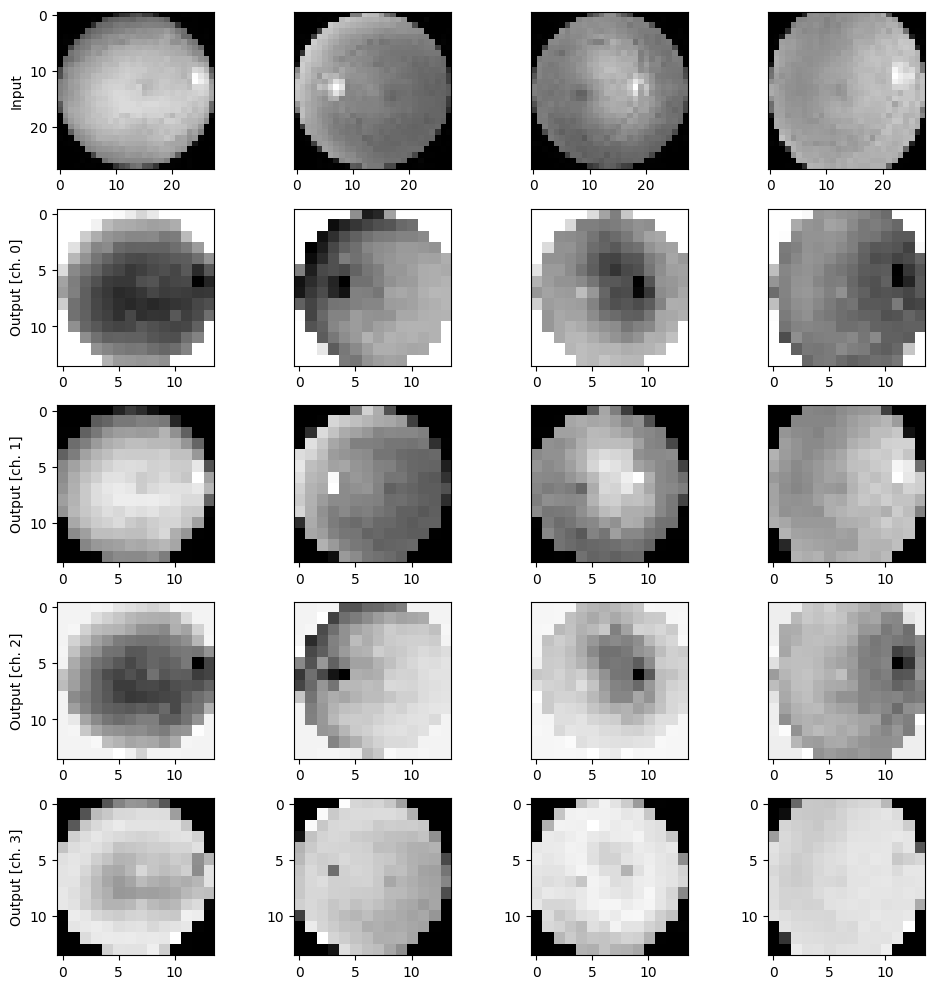

In [23]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [24]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        #keras.layers.Dense(5,activation='relu'),
        keras.layers.Dense(1,activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss="binary_crossentropy",#loss="sparse_categorical_crossentropy
        metrics=["accuracy"],
    )
    return model

In [25]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
342/342 - 1s - loss: 0.5772 - accuracy: 0.6964 - val_loss: 0.5141 - val_accuracy: 0.7494 - 772ms/epoch - 2ms/step
Epoch 2/30
342/342 - 0s - loss: 0.5224 - accuracy: 0.7388 - val_loss: 0.5063 - val_accuracy: 0.7543 - 269ms/epoch - 787us/step
Epoch 3/30
342/342 - 0s - loss: 0.5028 - accuracy: 0.7513 - val_loss: 0.4668 - val_accuracy: 0.7692 - 263ms/epoch - 770us/step
Epoch 4/30
342/342 - 0s - loss: 0.4924 - accuracy: 0.7571 - val_loss: 0.4813 - val_accuracy: 0.7692 - 263ms/epoch - 769us/step
Epoch 5/30
342/342 - 0s - loss: 0.4824 - accuracy: 0.7725 - val_loss: 0.4583 - val_accuracy: 0.7742 - 260ms/epoch - 761us/step
Epoch 6/30
342/342 - 0s - loss: 0.4761 - accuracy: 0.7703 - val_loss: 0.4542 - val_accuracy: 0.7767 - 265ms/epoch - 775us/step
Epoch 7/30
342/342 - 0s - loss: 0.4683 - accuracy: 0.7696 - val_loss: 0.4474 - val_accuracy: 0.7866 - 261ms/epoch - 764us/step
Epoch 8/30
342/342 - 0s - loss: 0.4608 - accuracy: 0.7922 - val_loss: 0.4471 - val_accuracy: 0.7866 - 264ms/epoch

In [26]:
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
342/342 - 1s - loss: 0.6693 - accuracy: 0.5677 - val_loss: 0.6320 - val_accuracy: 0.6576 - 622ms/epoch - 2ms/step
Epoch 2/30
342/342 - 0s - loss: 0.6112 - accuracy: 0.6811 - val_loss: 0.5856 - val_accuracy: 0.7345 - 265ms/epoch - 776us/step
Epoch 3/30
342/342 - 0s - loss: 0.5798 - accuracy: 0.7089 - val_loss: 0.5700 - val_accuracy: 0.6700 - 263ms/epoch - 770us/step
Epoch 4/30
342/342 - 0s - loss: 0.5620 - accuracy: 0.7125 - val_loss: 0.5641 - val_accuracy: 0.6774 - 260ms/epoch - 761us/step
Epoch 5/30
342/342 - 0s - loss: 0.5417 - accuracy: 0.7374 - val_loss: 0.5216 - val_accuracy: 0.7692 - 258ms/epoch - 755us/step
Epoch 6/30
342/342 - 0s - loss: 0.5308 - accuracy: 0.7330 - val_loss: 0.5211 - val_accuracy: 0.7122 - 262ms/epoch - 767us/step
Epoch 7/30
342/342 - 0s - loss: 0.5151 - accuracy: 0.7476 - val_loss: 0.4963 - val_accuracy: 0.7816 - 264ms/epoch - 773us/step
Epoch 8/30
342/342 - 0s - loss: 0.5059 - accuracy: 0.7593 - val_loss: 0.4903 - val_accuracy: 0.7519 - 262ms/epoch

C:\Users\User\AppData\Local\Temp\ipykernel_9948\925943430.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


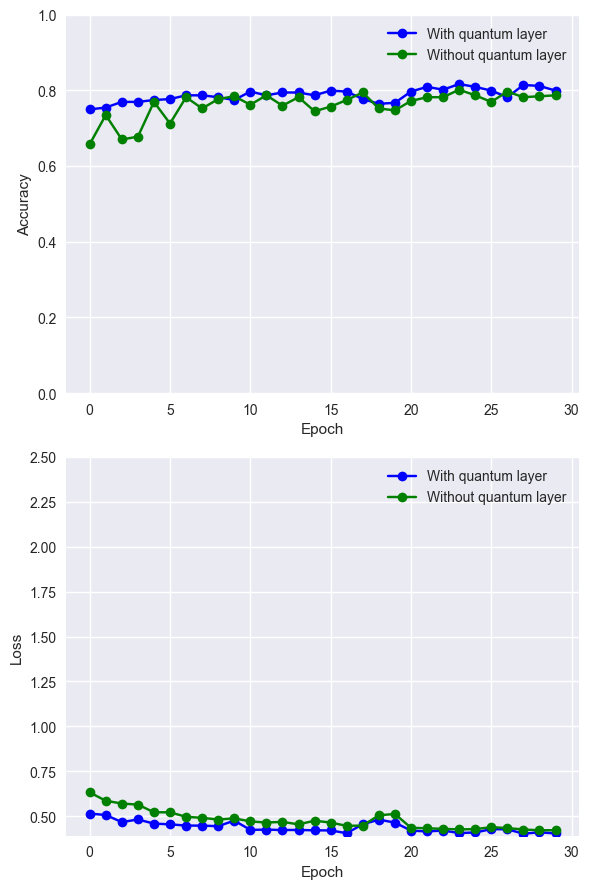

In [27]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()